In [64]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
#from sklearn.model_selection import train_test_split 
#from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

### Import data

In [65]:
#data = pd.concat([X, y_recovered, y_deaths, y_recovered_smoothed, y_deaths_smoothed], axis=1)

In [66]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-3].values

#Number of recovered
y_recovered = pd.read_csv('data.csv').iloc[:,-3].values

#Number of recovered with transformation to smooth data
y_rec_smoothed = pd.read_csv('data.csv').iloc[:,-1].values

## Quadratic Regularization

In [67]:
N = X.shape[1]

To do:
- Create matrix M
- Create matrix X (DONE)
- Compute X^TX
- Compute M^TM
- Verify M^TM value, if it coincides with the one G.O. wrote in report
- install library, define instances, run optimizer

In [68]:
pct_90 = int(np.ceil(90*len(X)/100))
pct_80 = int(np.ceil(80*len(X)/100))
pct_70 = int(np.ceil(70*len(X)/100))

X_train, X_test = X[:pct_80], X[pct_80:]
y_train, y_test =y_rec_smoothed[:pct_80], y_rec_smoothed[pct_80:]


In [69]:
import cvxopt

def create_M(N):
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==0:
                if j == 0:
                    M[i,j]=1
                else:
                    M[i,j]=0
            elif (i==j):
                M[i,j]=1
            elif (j == (i-1)):
                M[i,j] = -1
            else:
                M[i,j]=0
    return M

def generate_G(index):
    """index: represents k^*, gamma_{k^*} is such that gamma_0 <= gamma_1 <= ...<= gamma_{k^*} >= ... >= gamma_N
    This function generates a matrix G such that either gamma_index or gamma_{index+1} is the maximum
    """ 
    #this constraint verifies the gaussian-like distribution of the gamma
    G = np.zeros((N,N))
    for i in range(0, index):
        for j in range(N):
            if (i==j):
                G[i,j] = 1
            elif (j == i+1):
                G[i,j] = -1
                
    for i in range(index, N):
        for j in range(N):
            if (i==j):
                G[i,j] = -1
            elif (j == i+1):
                G[i,j] = 1
    
    # we do not put any condition on idx_th element, and use this line to verify that all gammas are superior or
    # equal to zero
    #G[index,:] = 0
    #G[index, 0] = -1

    
    #this constraint verifies that -gamma_i <= 0 <=> gamma_i >= 0 forall i
   # for i in range(N, 2*N):
    #    for j in range(N):
     #       if (i==N+j):
      #          G[i,j]=-1
    return G

def generate_params(X_train, y_train,k,lambda_=1.0):
    M = create_M(N)
    M_tilde = M.T @ M
    X_tilde = X_train.T @ X_train
    P = X_tilde + lambda_*(M_tilde)
    q = -X_train.T@y_train
    G = generate_G(k)
    h = np.zeros((N,1))
    for i in range(len(h)):
        h[i] = -0.0000001
    return P, q, G, h

def find_best_k(X_train, y_train, X_test, y_test, loss):
    """Returns index of maximum gamma that minimizes the mae loss"""
    loss = {}
    for k in range(N):
        P, q, G, h = generate_params(X_train, y_train, k)
        gammas = cvxopt_solve_qp(P,q, G, h)
        y_pred = X_test@gammas
        loss[k] = mape(y_test,y_pred)
    return min(loss, key=loss.get)


def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    
    return np.array(sol['x']).reshape((P.shape[1],))

# ----------------------------#
#        LOSS FUNCTIONS 
# ----------------------------#

def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

def mspe(y_test, y_pred):
    return np.mean(np.square((y_pred-y_test)/y_test))


# ----------------------------#
#        GENERATE PREDICTIONS 
# ----------------------------#

index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
P, q, G, h = generate_params(X_train, y_train, index)
gamma = cvxopt_solve_qp(P, q, G, h)
y_pred = X_test@gamma

     pcost       dcost       gap    pres   dres
 0: -7.9566e+06 -7.9566e+06  5e+01  8e+00  3e-09
 1: -7.9566e+06 -7.9566e+06  2e+01  4e+00  1e-09
 2: -7.9566e+06 -7.9563e+06  1e+02  4e+00  1e-09
 3: -7.9563e+06 -7.9558e+06  2e+02  2e+00  6e-10
 4: -7.9555e+06 -7.9548e+06  1e+03  2e+00  6e-10
 5: -7.9551e+06 -7.9546e+06  1e+03  1e+00  4e-10
 6: -7.9552e+06 -7.9539e+06  2e+03  1e+00  4e-10
 7: -7.9549e+06 -7.9536e+06  2e+03  9e-01  3e-10
 8: -7.9540e+06 -7.9529e+06  7e+02  3e-01  1e-10
 9: -7.9538e+06 -7.9526e+06  8e+02  3e-01  1e-10
10: -7.9533e+06 -7.9522e+06  7e+02  2e-01  6e-11
11: -7.9533e+06 -7.9507e+06  9e+02  2e-01  6e-11
12: -7.9521e+06 -7.9447e+06  2e+03  1e-01  4e-11
13: -7.9484e+06 -7.9386e+06  3e+03  1e-01  3e-11
14: -7.9476e+06 -7.9356e+06  5e+03  9e-02  3e-11
15: -7.9456e+06 -7.9332e+06  6e+03  7e-02  2e-11
16: -7.9426e+06 -7.9288e+06  6e+03  6e-02  2e-11
17: -7.9401e+06 -7.9215e+06  7e+03  5e-02  2e-11
18: -7.9300e+06 -7.8988e+06  1e+04  3e-02  1e-11
19: -7.9132e+06 -7.88

25: -7.6079e+06 -7.3138e+06  2e+05  4e-03  3e-12
26: -7.2320e+06 -7.2357e+06  4e+03  2e-18  3e-14
27: -7.2357e+06 -7.2357e+06  4e+01  1e-18  7e-15
28: -7.2357e+06 -7.2357e+06  4e-01  2e-18  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.9566e+06 -7.9566e+06  5e+01  8e+00  5e-09
 1: -7.9566e+06 -7.9566e+06  3e+01  4e+00  3e-09
 2: -7.9565e+06 -7.9559e+06  4e+02  4e+00  3e-09
 3: -7.9561e+06 -7.9557e+06  2e+02  2e+00  1e-09
 4: -7.9549e+06 -7.9548e+06  2e+03  2e+00  1e-09
 5: -7.9548e+06 -7.9547e+06  1e+03  9e-01  6e-10
 6: -7.9546e+06 -7.9541e+06  1e+03  7e-01  4e-10
 7: -7.9544e+06 -7.9538e+06  1e+03  4e-01  3e-10
 8: -7.9540e+06 -7.9527e+06  1e+03  4e-01  2e-10
 9: -7.9540e+06 -7.9512e+06  2e+03  3e-01  2e-10
10: -7.9531e+06 -7.9478e+06  2e+03  3e-01  2e-10
11: -7.9520e+06 -7.9451e+06  3e+03  2e-01  1e-10
12: -7.9521e+06 -7.9431e+06  3e+03  2e-01  1e-10
13: -7.9485e+06 -7.9284e+06  5e+03  2e-01  1e-10
14: -7.9420e+06 -7.9169e+06  9e+03  1e-01  8e-

In [70]:
gamma

array([6.06901612e-02, 1.44035242e-06, 1.32045550e-06, 1.20615788e-06,
       1.09656477e-06, 9.89681181e-07, 8.89589581e-07, 7.90725681e-07,
       6.91797686e-07, 5.92919317e-07, 4.94068046e-07, 3.95238285e-07,
       2.96426048e-07, 1.97617965e-07, 9.88147333e-08])

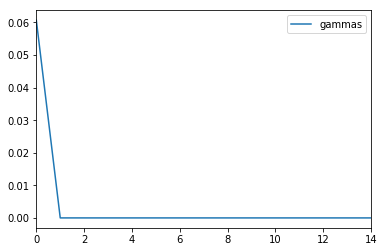

In [71]:
pd.DataFrame({'gammas': gamma}).plot()

In [72]:
index

0

In [73]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df


,Actual,Predicted
0,356.0,413.458985
1,468.0,389.056653
2,480.0,371.997853
3,405.0,360.037253
4,405.0,342.796962
5,423.0,321.854779
6,355.0,308.256204
7,267.0,297.328262
8,230.0,273.655695
9,230.0,248.890660


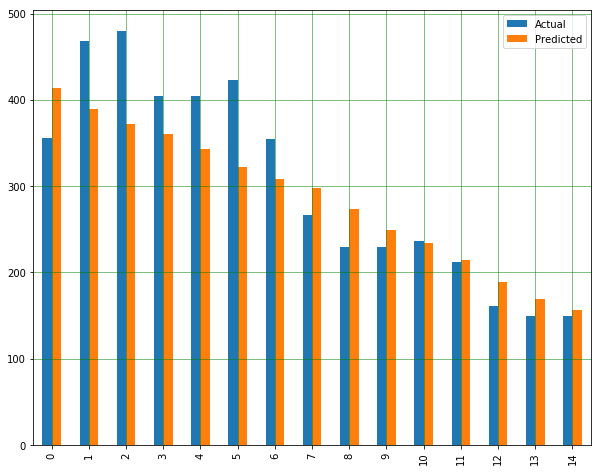

In [74]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [75]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute percentage error:', mape(y_test, y_pred))  
print('Mean Square percentage error:', mspe(y_test, y_pred))  






Mean Absolute Error: 43.432908500526814
Mean Squared Error: 2927.0905131242453
Root Mean Squared Error: 54.1025924806219
Mean Absolute percentage error: 0.12981339311494416
Mean Square percentage error: 0.021373723153809195


### Run same but delete columns 6: and then delete columns 4: (see diff)

In [76]:
X_4 = X[:,:4]
X_6 = X[:,:6]
N = X_4.shape[1]
pct_90 = int(np.ceil(90*len(X_4)/100))
pct_80 = int(np.ceil(80*len(X_4)/100))
pct_70 = int(np.ceil(70*len(X_4)/100))

X_train, X_test = X_4[:pct_80], X_4[pct_80:]
y_train, y_test =y_rec_smoothed[:pct_80], y_rec_smoothed[pct_80:]

In [77]:
index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
P, q, G, h = generate_params(X_train, y_train, index)
gamma = cvxopt_solve_qp(P, q, G, h)
y_pred = X_test@gamma



     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  2e-09
 1: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 2: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 3: -7.8231e+06 -7.8249e+06  3e+03  2e-01  2e-10
 4: -7.8242e+06 -7.8258e+06  5e+03  1e-01  1e-10
 5: -7.8243e+06 -7.8253e+06  3e+03  7e-02  7e-11
 6: -7.8228e+06 -7.8235e+06  5e+03  5e-02  5e-11
 7: -7.8233e+06 -7.8232e+06  2e+03  2e-02  2e-11
 8: -7.8236e+06 -7.8226e+06  4e+02  6e-03  6e-12
 9: -7.8219e+06 -7.8199e+06  5e+02  2e-03  2e-12
10: -7.8192e+06 -7.8193e+06  1e+02  2e-19  8e-16
11: -7.8193e+06 -7.8193e+06  1e+00  1e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  5e-09
 1: -7.8245e+06 -7.8245e+06  3e-01  2e-01  5e-10
 2: -7.8245e+06 -7.8245e+06  3e-01  2e-01  4e-10
 3: -7.8245e+06 -7.8244e+06  1e+01  2e-01  4e-10
 4: -7.8244e+06 -7.8242e+06  1e+02  1e-01  3e-10
 5: -7.8242e+06 -7.8240e+06  7e+01  5e-02  1e-1

In [78]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

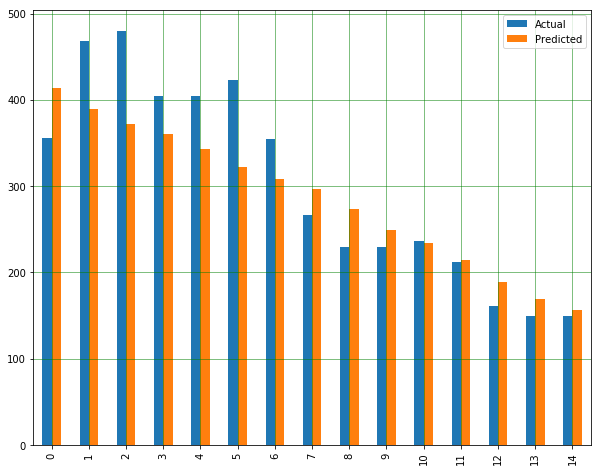

In [79]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [80]:
gamma


array([6.06956135e-02, 3.45994146e-06, 4.64769665e-07, 1.01725497e-07])

In [81]:
# X_4

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute percentage error:', mape(y_test, y_pred))  
print('Mean Square percentage error:', mspe(y_test, y_pred))  



Mean Absolute Error: 43.43345329260343
Mean Squared Error: 2928.0258358236524
Root Mean Squared Error: 54.111235763228066
Mean Absolute percentage error: 0.12979013198267406
Mean Square percentage error: 0.021370082293588125


## Cross Validation

### Four independent splits

Here, we use the model with **4 gammas** to perform cross validation in order to find the best parameters. As we have around 70 data points, and need at least twice the number of gammas as number of training points, we start with 10 data points. We estimate 10 data points for training, and three for validation. As we have $\frac{69}{13}= 5.3$, we will do five folds. Each fold has 14 points, except for last fold with 13. We validate on two last data points. 

If we split every 13 data points, this is what we get:

In [85]:
splits_X = np.array_split(X_4, 4, axis=0)
splits_y = np.array_split(y_rec_smoothed, 4, axis=0)


In [86]:
def cross_val(splits_X, splits_y,lambda_=1.0):  
    y_vals = []
    y_preds = []
    mapes = []
    maes = []

    for X, y in zip(splits_X, splits_y):
        pct_90 = int(np.floor(90*len(X)/100))

        X_train = X[:pct_90]
        X_val = X[pct_90:]
        y_train = y[:pct_90]
        y_val = y[pct_90:]
        index = find_best_k(X_train, y_train, X_val, y_val, 'mape')
        P, q, G, h = generate_params(X_train, y_train, index,lambda_)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_val@gamma

        y_vals.append(y_val)
        y_preds.append(y_pred)

        mapes.append(mape(y_val, y_pred))
        maes.append(metrics.mean_absolute_error(y_val, y_pred))
        
    y_vals = [item for sublist in y_vals for item in sublist]
    y_preds =[item for sublist in y_preds for item in sublist]
        
    return mapes, maes, y_vals, y_preds

mapes, maes, y_vals, y_preds = cross_val(splits_X, splits_y)

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


In [87]:
mapes

[inf, 0.06030789261007712, 0.12338588732046853, 0.04043513765013065]

In [88]:
maes

[0.9999577062936679, 57.306114821723725, 58.62578541278731, 6.065270647519597]

In [89]:
df = pd.DataFrame({'Actual': y_vals, 'Predicted': y_preds})
df


,Actual,Predicted
0,0.0,0.000343
1,2.0,0.000428
2,963.0,868.350810
3,894.0,913.963040
4,555.0,574.353452
5,462.0,559.898118
6,150.0,160.914623
7,150.0,148.784082


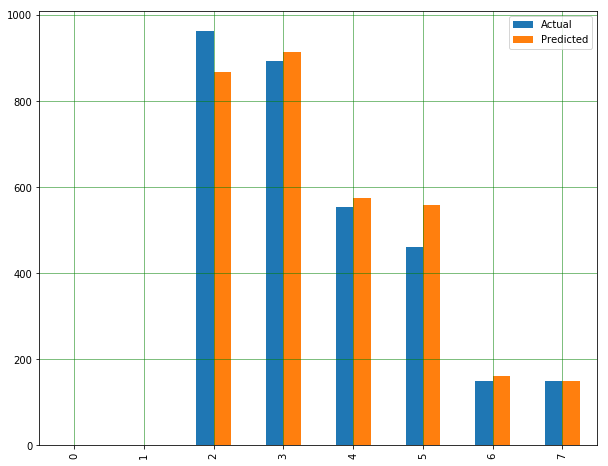

In [90]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Advancement validation

In [91]:
# We want our train set to be of size 40, and then we shift of 10 data points at each new iteration.
# the size of our test set is the rest of the dataset points
splits = int(np.floor((X_4.shape[0] - 40)/10))

##

mapes = []
maes = []
y_vals = []
y_preds = []

for i in range(splits):

    begin = 10*i
    end = 40 + 10*i
    
    X_tr = X_4[begin:end,:]
    y_tr = y_rec_smoothed[begin:end]
    
    X_te = X_4[end:,:]
    y_te = y_rec_smoothed[end:]
    
    # Run the model
    
    index = find_best_k(X_tr, y_tr, X_te, y_te, 'mape')
    P, q, G, h = generate_params(X_tr, y_tr, index,10e-5)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma

    y_vals.append(y_te)
    y_preds.append(y_pred)

    mapes.append(mape(y_te, y_pred))
    maes.append(metrics.mean_absolute_error(y_te, y_pred))
        
y_vals = [item for sublist in y_vals for item in sublist]
y_preds =[item for sublist in y_preds for item in sublist]
        

     pcost       dcost       gap    pres   dres
 0: -2.8104e+06 -2.8104e+06  1e+01  3e+00  1e-08
 1: -2.8104e+06 -2.8104e+06  3e+00  1e+00  6e-09
 2: -2.8004e+06 -2.7997e+06  9e+02  1e-01  4e-10
 3: -2.8003e+06 -2.7996e+06  8e+02  9e-02  3e-10
 4: -2.8003e+06 -2.7991e+06  8e+02  8e-02  3e-10
 5: -2.8004e+06 -2.7945e+06  1e+03  7e-02  3e-10
 6: -2.7883e+06 -2.7728e+06  9e+03  4e-02  1e-10
 7: -2.7677e+06 -2.7681e+06  4e+02  5e-18  6e-15
 8: -2.7681e+06 -2.7681e+06  4e+00  4e-18  3e-15
 9: -2.7681e+06 -2.7681e+06  4e-02  4e-18  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.8104e+06 -2.8104e+06  1e+01  3e+00  3e-08
 1: -2.8104e+06 -2.8104e+06  4e+00  1e+00  1e-08
 2: -2.8004e+06 -2.7997e+06  1e+03  1e-01  1e-09
 3: -2.8001e+06 -2.7995e+06  4e+02  4e-02  4e-10
 4: -2.7990e+06 -2.7992e+06  2e+02  2e-17  2e-16
 5: -2.7992e+06 -2.7992e+06  3e+00  9e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.8104e+06 -2.8104e

In [92]:
print('for each split we have the following MAPE losses: {}, \nResulting in a mean MAPE of {}'.format(mapes, np.mean(mapes)))


for each split we have the following MAPE losses: [0.4176654995049572, 0.15792956204327502, 0.1490922515489281], 
Resulting in a mean MAPE of 0.24156243769905342


# Find best hyperparameter $\lambda$

In [93]:
# this is the function we want to minimize
# we want to minimize the mean loss function MAE from our cross validation run
def f(lambda_):
    mapes, maes, y_vals, y_preds = cross_val(splits_X, splits_y, lambda_)
    return np.mean(maes)   

In [94]:
from scipy.optimize import minimize

minimize(f,1.0,method='SLSQP')

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


12: -5.0268e+06 -5.0268e+06  3e-03  8e-09  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0542e+06 -5.0542e+06  6e+00  3e+00  8e-09
 1: -5.0542e+06 -5.0542e+06  2e+00  9e-01  2e-09
 2: -5.0542e+06 -5.0541e+06  2e+00  8e-01  2e-09
 3: -5.0530e+06 -5.0520e+06  1e+03  5e-01  1e-09
 4: -5.0534e+06 -5.0494e+06  1e+03  4e-01  1e-09
 5: -5.0469e+06 -5.0419e+06  9e+01  1e-01  3e-10
 6: -5.0444e+06 -5.0413e+06  6e+01  6e-02  2e-10
 7: -5.0443e+06 -5.0382e+06  3e+02  6e-02  2e-10
 8: -5.0378e+06 -5.0237e+06  7e+03  5e-02  1e-10
 9: -5.0189e+06 -5.0178e+06  6e+02  2e-03  5e-12
10: -5.0178e+06 -5.0178e+06  7e+00  2e-05  6e-14
11: -5.0178e+06 -5.0178e+06  7e-02  2e-07  5e-15
12: -5.0178e+06 -5.0178e+06  7e-04  2e-09  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0542e+06 -5.0542e+06  6e+00  2e+00  4e-09
 1: -5.0542e+06 -5.0542e+06  8e-01  3e-01  6e-10
 2: -5.0542e+06 -5.0542e+06  7e-01  3e-01  6e-10
 3: -5.0541e+06 -5.0540

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     fun: 30.749282147081075
     jac: array([-2.38418579e-07])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.])

In [95]:
from skopt import gp_minimize
from skopt.space import Real, Integer

space  = [Real(10**-5, 10**0, name='learning_rate')]

res = gp_minimize(f,space)
lambda_ = res['x'][0]

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 5: -1.5297e+06 -1.5386e+06  9e+03  5e-04  7e-12
 6: -1.5314e+06 -1.5316e+06  2e+02  1e-05  2e-13
 7: -1.5315e+06 -1.5315e+06  2e+00  1e-07  2e-15
 8: -1.5315e+06 -1.5315e+06  2e-02  1e-09  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  6e-08
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  5e-08
 2: -1.5580e+06 -1.5326e+06  2e+05  7e+00  5e-08
 3: -1.5404e+06 -1.5308e+06  2e+04  1e+00  7e-09
 4: -1.5440e+06 -1.5125e+06  2e+04  8e-01  5e-09
 5: -1.5159e+06 -1.5070e+06  5e+02  1e-01  7e-10
 6: -1.5154e+06 -1.5002e+06  1e+03  1e-01  6e-10
 7: -1.4956e+06 -1.4710e+06  2e+04  7e-02  4e-10
 8: -1.4684e+06 -1.4658e+06  4e+02  3e-03  2e-11
 9: -1.4658e+06 -1.4657e+06  5e+00  3e-05  2e-13
10: -1.4657e+06 -1.4657e+06  5e-02  3e-07  9e-14
11: -1.4657e+06 -1.4657e+06  5e-04  3e-09  1e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0542e+06 -5.0542e+06  6e+00  2e+00  4e-09
 1: -5.0542e+06 -5.0542

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 0: -1.6365e+06 -1.6364e+06  3e+01  1e+01  8e-08
 1: -1.6365e+06 -1.6362e+06  1e+01  8e+00  6e-08
 2: -1.1501e+06 -1.6692e+06  1e+06  7e+00  6e-08
 3: -1.1538e+06 -1.7870e+06  2e+06  7e+00  6e-08
 4: -1.2727e+06 -1.6273e+06  2e+06  6e+00  5e-08
 5: -1.3956e+06 -1.5756e+06  4e+05  7e-01  6e-09
 6: -1.5066e+06 -1.5450e+06  5e+04  3e-02  3e-10
 7: -1.4885e+06 -1.5286e+06  4e+04  2e-02  2e-10
 8: -1.4947e+06 -1.5166e+06  2e+04  1e-02  9e-11
 9: -1.5116e+06 -1.5312e+06  2e+04  6e-03  5e-11
10: -1.5135e+06 -1.5145e+06  1e+03  2e-04  2e-12
11: -1.5139e+06 -1.5139e+06  1e+01  2e-06  2e-14
12: -1.5139e+06 -1.5139e+06  1e-01  2e-08  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  1e-07
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  1e-07
 2: -1.2898e+06 -1.6807e+06  7e+05  7e+00  1e-07
 3: -1.5453e+06 -1.5950e+06  1e+06  7e+00  1e-07
 4: -1.4977e+06 -1.5413e+06  7e+04  1e-01  2e-09
 5: -1.5297e+06 -1.5386e+06  9e+03  5e-04  7e-

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide



 0: -1.6365e+06 -1.6364e+06  6e+01  1e+01  6e-08
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  5e-08
 2: -1.5580e+06 -1.5326e+06  2e+05  7e+00  5e-08
 3: -1.5404e+06 -1.5308e+06  2e+04  1e+00  7e-09
 4: -1.5440e+06 -1.5125e+06  2e+04  8e-01  5e-09
 5: -1.5159e+06 -1.5070e+06  5e+02  1e-01  7e-10
 6: -1.5153e+06 -1.5002e+06  1e+03  1e-01  6e-10
 7: -1.4955e+06 -1.4710e+06  2e+04  7e-02  4e-10
 8: -1.4684e+06 -1.4658e+06  4e+02  3e-03  2e-11
 9: -1.4658e+06 -1.4657e+06  5e+00  3e-05  2e-13
10: -1.4657e+06 -1.4657e+06  5e-02  3e-07  1e-13
11: -1.4657e+06 -1.4657e+06  5e-04  3e-09  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  1e-07
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  1e-07
 2: -1.3534e+06 -1.5732e+06  6e+05  7e+00  1e-07
 3: -1.5152e+06 -1.6254e+06  1e+06  7e+00  1e-07
 4: -1.4497e+06 -1.5263e+06  1e+05  2e-01  3e-09
 5: -1.4967e+06 -1.5081e+06  1e+04  3e-16  5e-16
 6: -1.5061e+06 -1.5077e+06  2e+03  2e-18  1e

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 8: -5.0435e+06 -5.0352e+06  2e+03  6e-02  1e-10
 9: -5.0278e+06 -5.0269e+06  3e+03  6e-03  2e-11
10: -5.0269e+06 -5.0268e+06  3e+01  8e-05  2e-13
11: -5.0268e+06 -5.0268e+06  3e-01  8e-07  2e-15
12: -5.0268e+06 -5.0268e+06  3e-03  8e-09  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.0542e+06 -5.0542e+06  6e+00  3e+00  8e-09
 1: -5.0542e+06 -5.0542e+06  2e+00  9e-01  2e-09
 2: -5.0542e+06 -5.0541e+06  2e+00  8e-01  2e-09
 3: -5.0530e+06 -5.0520e+06  1e+03  5e-01  1e-09
 4: -5.0534e+06 -5.0494e+06  1e+03  4e-01  1e-09
 5: -5.0469e+06 -5.0419e+06  9e+01  1e-01  3e-10
 6: -5.0444e+06 -5.0413e+06  6e+01  6e-02  2e-10
 7: -5.0443e+06 -5.0382e+06  3e+02  6e-02  2e-10
 8: -5.0378e+06 -5.0237e+06  7e+03  5e-02  1e-10
 9: -5.0189e+06 -5.0178e+06  6e+02  2e-03  5e-12
10: -5.0178e+06 -5.0178e+06  7e+00  2e-05  6e-14
11: -5.0178e+06 -5.0178e+06  7e-02  2e-07  5e-15
12: -5.0178e+06 -5.0178e+06  7e-04  2e-09  5e-15
Optimal solution found.
     pcost       dcost

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide



 7:  4.3755e-14  2.6851e-12  1e-13  2e-07  1e-19
 8:  7.7191e-14  2.5119e-12  2e-13  2e-07  2e-19
 9:  1.1974e-10 -1.1874e-11  1e-10  2e-22  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.7491e-16  3.7169e-14  4e-07  2e+00  1e-19
 1:  7.7491e-16  3.7169e-14  4e-09  2e-02  3e-19
 2:  7.7493e-16  3.7170e-14  4e-11  2e-04  2e-19
 3:  7.7710e-16  3.7240e-14  4e-13  2e-06  5e-20
 4:  9.7233e-16  4.3740e-14  1e-14  2e-07  2e-19
 5:  3.2272e-15  1.9154e-13  2e-14  2e-07  3e-19
 6:  7.0351e-15  8.2501e-13  7e-14  2e-07  3e-19
 7:  5.6993e-11  2.4980e-11  3e-11  3e-22  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.233

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 3:  4.2535e-16  3.8503e-14  4e-13  2e-06  9e-20
 4:  5.2620e-16  4.5473e-14  9e-15  2e-07  6e-20
 5:  6.0564e-16  2.0461e-13  2e-14  2e-07  2e-19
 6:  2.4973e-14  1.7800e-12  9e-14  2e-07  1e-19
 7:  4.3755e-14  2.6851e-12  1e-13  2e-07  1e-19
 8:  7.7191e-14  2.5119e-12  2e-13  2e-07  2e-19
 9:  1.1974e-10 -1.1874e-11  1e-10  2e-22  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.7491e-16  3.7169e-14  4e-07  2e+00  1e-19
 1:  7.7491e-16  3.7169e-14  4e-09  2e-02  3e-19
 2:  7.7493e-16  3.7170e-14  4e-11  2e-04  2e-19
 3:  7.7710e-16  3.7240e-14  4e-13  2e-06  5e-20
 4:  9.7233e-16  4.3740e-14  1e-14  2e-07  2e-19
 5:  3.2272e-15  1.9154e-13  2e-14  2e-07  3e-19
 6:  7.0351e-15  8.2501e-13  7e-14  2e-07  3e-19
 7:  5.6993e-11  2.4980e-11  3e-11  3e-22  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  1e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  7e-21
 2:  6.3806e-18  3.9979

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 6: -1.5153e+06 -1.5002e+06  1e+03  1e-01  6e-10
 7: -1.4955e+06 -1.4710e+06  2e+04  7e-02  4e-10
 8: -1.4684e+06 -1.4658e+06  4e+02  3e-03  2e-11
 9: -1.4658e+06 -1.4657e+06  5e+00  3e-05  2e-13
10: -1.4657e+06 -1.4657e+06  5e-02  3e-07  1e-13
11: -1.4657e+06 -1.4657e+06  5e-04  3e-09  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  1e-07
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  1e-07
 2: -1.3534e+06 -1.5732e+06  6e+05  7e+00  1e-07
 3: -1.5152e+06 -1.6254e+06  1e+06  7e+00  1e-07
 4: -1.4497e+06 -1.5263e+06  1e+05  2e-01  3e-09
 5: -1.4967e+06 -1.5081e+06  1e+04  3e-16  5e-16
 6: -1.5061e+06 -1.5077e+06  2e+03  2e-18  1e-16
 7: -1.5065e+06 -1.5065e+06  2e+01  2e-17  1e-16
 8: -1.5065e+06 -1.5065e+06  2e-01  3e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6364e+06  3e+01  1e+01  8e-08
 1: -1.6365e+06 -1.6362e+06  1e+01  8e+00  6e-08
 2: -1.1501e+06 -1.6692

 5: -1.5159e+06 -1.5070e+06  5e+02  1e-01  7e-10
 6: -1.5153e+06 -1.5002e+06  1e+03  1e-01  6e-10
 7: -1.4955e+06 -1.4710e+06  2e+04  7e-02  4e-10
 8: -1.4684e+06 -1.4658e+06  4e+02  3e-03  2e-11
 9: -1.4658e+06 -1.4657e+06  5e+00  3e-05  2e-13
10: -1.4657e+06 -1.4657e+06  5e-02  3e-07  1e-13
11: -1.4657e+06 -1.4657e+06  5e-04  3e-09  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  1e-07
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  1e-07
 2: -1.3534e+06 -1.5732e+06  6e+05  7e+00  1e-07
 3: -1.5152e+06 -1.6254e+06  1e+06  7e+00  1e-07
 4: -1.4497e+06 -1.5263e+06  1e+05  2e-01  3e-09
 5: -1.4967e+06 -1.5081e+06  1e+04  3e-16  5e-16
 6: -1.5061e+06 -1.5077e+06  2e+03  2e-18  1e-16
 7: -1.5065e+06 -1.5065e+06  2e+01  2e-17  1e-16
 8: -1.5065e+06 -1.5065e+06  2e-01  3e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6364e+06  3e+01  1e+01  8e-08
 1: -1.6365e+06 -1.6362

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 8: -1.4684e+06 -1.4658e+06  4e+02  3e-03  2e-11
 9: -1.4658e+06 -1.4657e+06  5e+00  3e-05  2e-13
10: -1.4657e+06 -1.4657e+06  5e-02  3e-07  1e-13
11: -1.4657e+06 -1.4657e+06  5e-04  3e-09  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6365e+06  6e+01  1e+01  1e-07
 1: -1.6365e+06 -1.6363e+06  4e+01  8e+00  1e-07
 2: -1.3534e+06 -1.5732e+06  6e+05  7e+00  1e-07
 3: -1.5152e+06 -1.6254e+06  1e+06  7e+00  1e-07
 4: -1.4497e+06 -1.5263e+06  1e+05  2e-01  3e-09
 5: -1.4967e+06 -1.5081e+06  1e+04  3e-16  5e-16
 6: -1.5061e+06 -1.5077e+06  2e+03  2e-18  1e-16
 7: -1.5065e+06 -1.5065e+06  2e+01  2e-17  1e-16
 8: -1.5065e+06 -1.5065e+06  2e-01  3e-17  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6365e+06 -1.6364e+06  3e+01  1e+01  8e-08
 1: -1.6365e+06 -1.6362e+06  1e+01  8e+00  6e-08
 2: -1.1501e+06 -1.6692e+06  1e+06  7e+00  6e-08
 3: -1.1538e+06 -1.7870e+06  2e+06  7e+00  6e-08
 4: -1.2727e+06 -1.6273

 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-21
 5:  2.1071e-15  2.0609e-13  2e-14  2e-07  8e-20
 6:  2.6922e-15  9.3274e-13  6e-14  2e-07  8e-20
 7:  5.4135e-13  2.0713e-11  3e-13  2e-07  1e-18
 8:  2.4223e-09 -1.0008e-09  3e-09  5e-22  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2421e-16  3.8429e-14  4e-07  2e+00  1e-19
 1:  4.2421e-16  3.8429e-14  4e-09  2e-02  1e-19
 2:  4.2422e-16  3.8429

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-21
 5:  2.1071e-15  2.0609e-13  2e-14  2e-07  8e-20
 6:  2.6922e-15  9.3274e-13  6e-14  2e-07  8e-20
 7:  5.4135e-13  2.0713e-11  3e-13  2e-07  1e-18
 8:  2.4223e-09 -1.0008e-09  3e-09  5e-22  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2421e-16  3.8429e-14  4e-07  2e+00  1e-19
 1:  4.2421e-16  3.8429e-14  4e-09  2e-02  1e-19
 2:  4.2422e-16  3.8429e-14  4e-11  2e-04  6e-20
 3:  4.2535e-16  3.8503e-14  4e-13  2e-06  9e-20
 4:  5.2620e-16  4.5473

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide



 5:  2.1071e-15  2.0609e-13  2e-14  2e-07  8e-20
 6:  2.6922e-15  9.3274e-13  6e-14  2e-07  8e-20
 7:  5.4135e-13  2.0713e-11  3e-13  2e-07  1e-18
 8:  2.4223e-09 -1.0008e-09  3e-09  5e-22  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2421e-16  3.8429e-14  4e-07  2e+00  1e-19
 1:  4.2421e-16  3.8429e-14  4e-09  2e-02  1e-19
 2:  4.2422e-16  3.8429e-14  4e-11  2e-04  6e-20
 3:  4.2535e-16  3.8503e-14  4e-13  2e-06  9e-20
 4:  5.2620e-16  4.5473e-14  9e-15  2e-07  6e-20
 5:  6.0564e-16  2.0461e-13  2e-14  2e-07  2e-19
 6:  2.4973e-14  1.7800e-12  9e-14  2e-07  1e-19
 7:  4.3755e-14  2.6851e-12  1e-13  2e-07  1e-19
 8:  7.7191e-14  2.5119e-12  2e-13  2e-07  2e-19
 9:  1.1974e-10 -1.1874e-11  1e-10  2e-22  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.7491e-16  3.7169e-14  4e-07  2e+00  1e-19
 1:  7.7491e-16  3.7169e-14  4e-09  2e-02  3e-19
 2:  7.7493e-16  3.7170e-14  4e-11  2e-04  2e-19
 3:  7.7710e-16  3.724

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-21
 5:  2.1071e-15  2.0609e-13  2e-14  2e-07  8e-20
 6:  2.6922e-15  9.3274e-13  6e-14  2e-07  8e-20
 7:  5.4135e-13  2.0713e-11  3e-13  2e-07  1e-18
 8:  2.4223e-09 -1.0008e-09  3e-09  5e-22  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2421e-16  3.8429e-14  4e-07  2e+00  1e-19
 1:  4.2421e-16  3.8429e-14  4e-09  2e-02  1e-19
 2:  4.2422e-16  3.8429e-14  4e-11  2e-04  6e-20
 3:  4.2535e-16  3.8503e-14  4e-13  2e-06  9e-20
 4:  5.2620e-16  4.5473e-14  9e-15  2e-07  6e-20
 5:  6.0564e-16  2.0461e-13  2e-14  2e-07  2e-19
 6:  2.4973e-14  1.7800e-12  9e-14  2e-07  1e-19
 7:  4.3755e-14  2.6851e-12  1e-13  2e-07  1e-19
 8:  7.7191e-14  2.5119e-12  2e-13  2e-07  2e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


     pcost       dcost       gap    pres   dres
 0:  6.3804e-18  3.9978e-14  4e-07  2e+00  2e-20
 1:  6.3804e-18  3.9978e-14  4e-09  2e-02  1e-20
 2:  6.3806e-18  3.9979e-14  4e-11  2e-04  7e-21
 3:  6.4008e-18  4.0058e-14  4e-13  2e-06  2e-20
 4:  8.3491e-18  4.7610e-14  5e-15  2e-07  6e-21
 5:  1.2852e-16  3.7495e-13  1e-14  2e-07  5e-20
 6:  6.6878e-15  6.2334e-12  1e-13  2e-07  2e-19
 7:  4.4572e-15  2.6157e-11  4e-13  2e-07  2e-19
 8:  3.1973e-13  3.0226e-10  4e-12  2e-07  6e-19
 9:  3.2250e-06 -2.2626e-06  5e-06  1e-21  1e-12
10:  6.0517e-07 -1.8824e-07  8e-07  3e-22  8e-12
11:  1.6035e-07  5.4263e-08  1e-07  6e-23  4e-15
12:  8.0065e-08  7.1586e-08  8e-09  6e-23  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5796e-16  3.9131e-14  4e-07  2e+00  7e-20
 1:  2.5796e-16  3.9131e-14  4e-09  2e-02  7e-20
 2:  2.5797e-16  3.9132e-14  4e-11  2e-04  8e-20
 3:  2.5881e-16  3.9208e-14  4e-13  2e-06  3e-20
 4:  3.3933e-16  4.6375e-14  8e-15  2e-07  8e-2

In [96]:
def plot_loss_per_lambda():
    lambdas = [-10,-1,0, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10]
    mapes = []
    for l in lambdas:
        X_train = X_4[:pct_80]
        X_test = X_4[pct_80:]
        y_train = y_recovered[:pct_80]
        y_test = y_recovered[pct_80:]
        #print(X_test@gamma)
        #print(y_test)
        index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
        P, q, G, h = generate_params(X_train, y_train, index,l)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_test@gamma
        mapes.append(format(100*mape(y_test, y_pred),'.20'))
    print(mapes)
    print(len(mapes) == len(np.unique(mapes)))
    lambdas1 = ['-10','-1','0','10e-5', '10e-4', '10e-3', '10e-2', '10e-1', '1', '10']
    plt.plot(lambdas1, mapes, 'b')
        #plt.xlabel('Day')
        #plt.ylabel('Number of Daily Recovered')
        #plt.legend(['Predicted value','True value'])
        #plt.title('Baseline Prediction model for k=' + str(k))
        #plt.axvline(x=pct_80-1)

    

     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  2e-09
 1: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 2: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 3: -7.8231e+06 -7.8249e+06  3e+03  2e-01  2e-10
 4: -7.8242e+06 -7.8258e+06  5e+03  1e-01  1e-10
 5: -7.8243e+06 -7.8253e+06  3e+03  7e-02  7e-11
 6: -7.8228e+06 -7.8235e+06  5e+03  5e-02  5e-11
 7: -7.8233e+06 -7.8232e+06  2e+03  2e-02  2e-11
 8: -7.8236e+06 -7.8226e+06  4e+02  6e-03  6e-12
 9: -7.8219e+06 -7.8199e+06  5e+02  2e-03  2e-12
10: -7.8192e+06 -7.8193e+06  1e+02  2e-19  8e-16
11: -7.8193e+06 -7.8193e+06  1e+00  1e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  5e-09
 1: -7.8245e+06 -7.8245e+06  3e-01  2e-01  5e-10
 2: -7.8245e+06 -7.8245e+06  3e-01  2e-01  4e-10
 3: -7.8245e+06 -7.8244e+06  1e+01  2e-01  4e-10
 4: -7.8244e+06 -7.8242e+06  1e+02  1e-01  3e-10
 5: -7.8242e+06 -7.8240e+06  7e+01  5e-02  1e-1

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide



 5: -7.8243e+06 -7.8253e+06  3e+03  7e-02  7e-11
 6: -7.8228e+06 -7.8235e+06  5e+03  5e-02  5e-11
 7: -7.8233e+06 -7.8232e+06  2e+03  2e-02  2e-11
 8: -7.8236e+06 -7.8226e+06  4e+02  6e-03  6e-12
 9: -7.8219e+06 -7.8199e+06  5e+02  2e-03  2e-12
10: -7.8192e+06 -7.8193e+06  1e+02  2e-19  8e-16
11: -7.8193e+06 -7.8193e+06  1e+00  1e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  2e-09
 1: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 2: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 3: -7.8231e+06 -7.8249e+06  3e+03  2e-01  2e-10
 4: -7.8242e+06 -7.8258e+06  5e+03  1e-01  1e-10
 5: -7.8243e+06 -7.8253e+06  3e+03  7e-02  7e-11
 6: -7.8228e+06 -7.8235e+06  5e+03  5e-02  5e-11
 7: -7.8233e+06 -7.8232e+06  2e+03  2e-02  2e-11
 8: -7.8236e+06 -7.8226e+06  4e+02  6e-03  6e-12
 9: -7.8219e+06 -7.8199e+06  5e+02  2e-03  2e-12
10: -7.8192e+06 -7.8193e+06  1e+02  2e-19  8e-16
11: -7.8193e+06 -7.8193e+06  1e+00  1e-17  5e

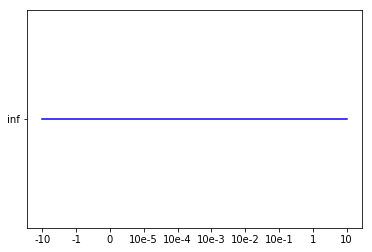

In [97]:
plot_loss_per_lambda()

In [98]:
def plot_gammas_per_lambda():
    lambdas = [-10, -1, 0, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1, 10]
    gammas = []
    for l in lambdas:
        X_train = X_4[:pct_80]
        X_test = X_4[pct_80:]
        y_train = y_recovered[:pct_80]
        y_test = y_recovered[pct_80:]
        #print(X_test@gamma)
        #print(y_test)
        index = find_best_k(X_train, y_train, X_test, y_test, 'mape')
        P, q, G, h = generate_params(X_train, y_train, index,l)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_test@gamma
        gammas.append(format(np.mean(gamma), '.20f'))
    print(gammas)
    lambdas1 = ['-10','-1','0','10e-5', '10e-4', '10e-3', '10e-2', '10e-1', '1', '10']

    plt.plot(lambdas1, gammas, 'b')
        #plt.xlabel('Day')
        #plt.ylabel('Number of Daily Recovered')
        #plt.legend(['Predicted value','True value'])
        #plt.title('Baseline Prediction model for k=' + str(k))
        #plt.axvline(x=pct_80-1)

    

     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  2e-09
 1: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 2: -7.8245e+06 -7.8245e+06  4e-01  2e-01  2e-10
 3: -7.8231e+06 -7.8249e+06  3e+03  2e-01  2e-10
 4: -7.8242e+06 -7.8258e+06  5e+03  1e-01  1e-10
 5: -7.8243e+06 -7.8253e+06  3e+03  7e-02  7e-11
 6: -7.8228e+06 -7.8235e+06  5e+03  5e-02  5e-11
 7: -7.8233e+06 -7.8232e+06  2e+03  2e-02  2e-11
 8: -7.8236e+06 -7.8226e+06  4e+02  6e-03  6e-12
 9: -7.8219e+06 -7.8199e+06  5e+02  2e-03  2e-12
10: -7.8192e+06 -7.8193e+06  1e+02  2e-19  8e-16
11: -7.8193e+06 -7.8193e+06  1e+00  1e-17  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8245e+06 -7.8245e+06  5e+00  2e+00  5e-09
 1: -7.8245e+06 -7.8245e+06  3e-01  2e-01  5e-10
 2: -7.8245e+06 -7.8245e+06  3e-01  2e-01  4e-10
 3: -7.8245e+06 -7.8244e+06  1e+01  2e-01  4e-10
 4: -7.8244e+06 -7.8242e+06  1e+02  1e-01  3e-10
 5: -7.8242e+06 -7.8240e+06  7e+01  5e-02  1e-1

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


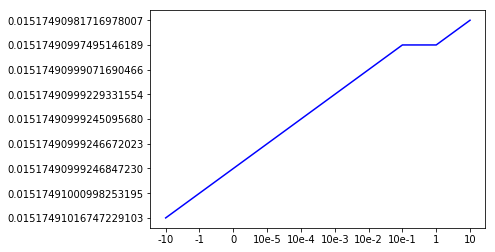

In [99]:
plot_gammas_per_lambda()